<a href="https://colab.research.google.com/github/sergiorolnic/datascience/blob/main/datascience_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Box Office Prediction
**Programmazione di Applicazioni Data Intensive**

Ingegneria e Scienze Informatiche 2021

Sergiu Gabriel Rolnic

Il seguente progetto riguarda l'analisi  dei dati raccolti dal sito [The Movie Database](https://www.themoviedb.org/). Lo scopo finale sarà quello di prevedere gli incassi di un film avendo a disposizione solo dati esistenti prima della effettiva uscita nelle sale.


# **Analisi dei Dati**

Importazione del dataset e delle librerie utili per la sua analisi

In [86]:
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [87]:
if not os.path.exists("train.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://raw.githubusercontent.com/sergiorolnic/datascience/main/train.csv", "train.csv")

data = pd.read_csv("train.csv")    

In [88]:

if not os.path.exists("test.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://raw.githubusercontent.com/sergiorolnic/datascience/main/test.csv", "test.csv")

test = pd.read_csv("test.csv") 

In [89]:
data.shape

(3000, 23)

In [90]:
data.head(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651


In [91]:
data.tail(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
2999,3000,NaN,35000000,"[{'id': 53, 'name': 'Thriller'}, {'id': 28, 'n...",http://www.abductionthefilm.com/,tt1600195,en,Abduction,A young man sets out to uncover the truth abou...,10.512109,/cUT6NQP5LAJpmUoStGtXmvNt4zA.jpg,"[{'name': 'Lions Gate Films', 'id': 35}, {'nam...","[{'iso_3166_1': 'US', 'name': 'United States o...",9/22/11,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,They stole his life. He's taking it back.,Abduction,"[{'id': 591, 'name': 'cia'}, {'id': 822, 'name...","[{'cast_id': 2, 'character': 'Nathan Harper', ...","[{'credit_id': '5391990d0e0a260fb5001629', 'de...",82087155


Notiamo la presenza di feature particolari: dizionari con una o piu' entrate, valori numerici su scale diverse, stringhe di varia natura. La challenge principale sarà quella di riuscire ad estrarre delle informazione utili da piu' variabili possibili.   

La colonna "id" può essere usata come indice del nostro dataframe

In [92]:
data = pd.read_csv("train.csv", index_col=0)  
test = pd.read_csv("test.csv", index_col=0)  

In [93]:
data.shape

(3000, 22)

In [94]:
test.shape

(4398, 21)

In [95]:
data.head(1)

,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
id,,,,,,,,,,,,,,,,,,,,,,
1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651


## Gestione Features



*   *belongs_to_collection*: appartenenza ad una serie cinematografica
*   *budget*: costo di produzione
*   *genres*: generi
*   *homepage*: link al sito web


*   *imdb_id*: id imbd

*   *original_language*: lingua originale

*   *original_title*: titolo originale

*   *overview*: plot
*   *popularity*: popolarità
*   *poster_path*: path della locandina ufficiale
*   *production_companies*: compagnia di produzione
*   *production_countries*: paese di produzione
*   *release_date*: data di uscita
*   *runtime*: durata
*   *spoken_languages*: lingua del film
*   *status*: stato del rilascio
*   *tagline*: slogan film
*   *title*: titolo
*   *Keywords*: parole chiavi
*   *cast*: cast
*   *crew*: trop
*   *revenue*: incasso del film --> variabile da predire

In [96]:
data.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 1 to 3000
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   belongs_to_collection  604 non-null    object 
 1   budget                 3000 non-null   int64  
 2   genres                 2993 non-null   object 
 3   homepage               946 non-null    object 
 4   imdb_id                3000 non-null   object 
 5   original_language      3000 non-null   object 
 6   original_title         3000 non-null   object 
 7   overview               2992 non-null   object 
 8   popularity             3000 non-null   float64
 9   poster_path            2999 non-null   object 
 10  production_companies   2844 non-null   object 
 11  production_countries   2945 non-null   object 
 12  release_date           3000 non-null   object 
 13  runtime                2998 non-null   float64
 14  spoken_languages       2980 non-null   object 
 15  stat

In [97]:
data.describe()

,budget,popularity,runtime,revenue
count,3.000000e+03,3000.000000,2998.000000,3.000000e+03
mean,2.253133e+07,8.463274,107.856571,6.672585e+07
std,3.702609e+07,12.104000,22.086434,1.375323e+08
min,0.000000e+00,0.000001,0.000000,1.000000e+00
25%,0.000000e+00,4.018053,94.000000,2.379808e+06
50%,8.000000e+06,7.374861,104.000000,1.680707e+07
75%,2.900000e+07,10.890983,118.000000,6.891920e+07
max,3.800000e+08,294.337037,338.000000,1.519558e+09


Verifichiamo la presenza di valori null


In [98]:
data.isnull().sum()

belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [99]:
test.isnull().sum()

belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

Analizziamo le features individualmente ed eventualmente evidenziamo eventuali rapporti tra esse o con la variabile target

 Notiamo che **Belongs_to_collection** e **Homepage** presentano una preponderanza di valori null. Si decide perciò di binarizzarle attraverso il quesito "Is Present?" in quanto sono features che potrebbero risultare particolarmente utili durante l'addestramento.

In [100]:
data['belongs_to_a_collection'] = data['belongs_to_collection'].apply(lambda x: 0 if pd.isna(x) else 1)
data = data.drop(columns='belongs_to_collection')

data['homepage_is_present'] = data['homepage'].apply(lambda x: 0 if pd.isna(x) else 1)
data = data.drop(columns='homepage')



In [101]:
test['belongs_to_a_collection'] = test['belongs_to_collection'].apply(lambda x: 0 if pd.isna(x) else 1)
test = test.drop(columns='belongs_to_collection')

test['homepage_is_present'] = test['homepage'].apply(lambda x: 0 if pd.isna(x) else 1)
test = test.drop(columns='homepage')

**Budget**



Osserviamo la distribuzione del budget e della sua funzione logaritmica in modo da uniformare il piu' possibile i dati.

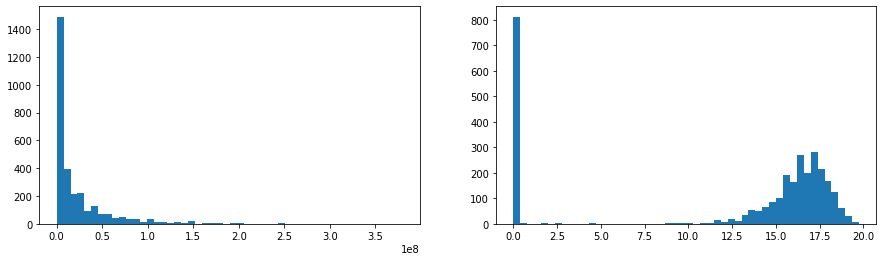

In [102]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1).hist(data.budget,50)
plt.subplot(1, 2, 2).hist(np.log1p(data.budget),50);



In [103]:
data.budget[data.budget>1000000].count()

2012

La quasi totalità dei valori non nulli sono superiori al milione, perciò possiamo togliere le righe con valori inferiori, oppure usare la media dei valori superiori. Si opta per la seconda soluzione a causa della ridotta disponibilità di dati.

In [104]:
#data.budget[data.budget<1000000] = data.budget[data.budget>1000000].mean();
data = data[data.budget > 1000000]


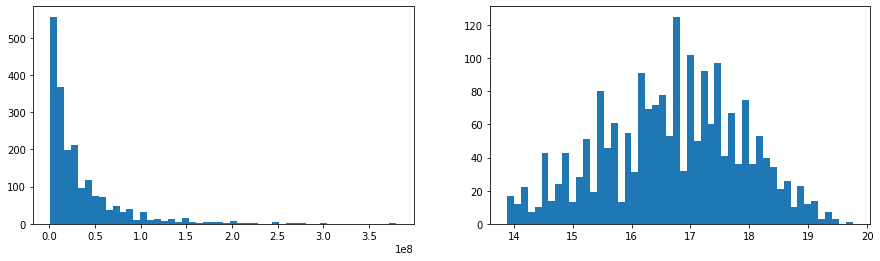

In [105]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1).hist(data.budget,50)
plt.subplot(1, 2, 2).hist(np.log1p(data.budget),50);

**Budget** è l'unica feature che presenta delle caratteristiche simili alla variabile target **revenue**, perciò si decide di verificare un'eventuale correlazione tra le due

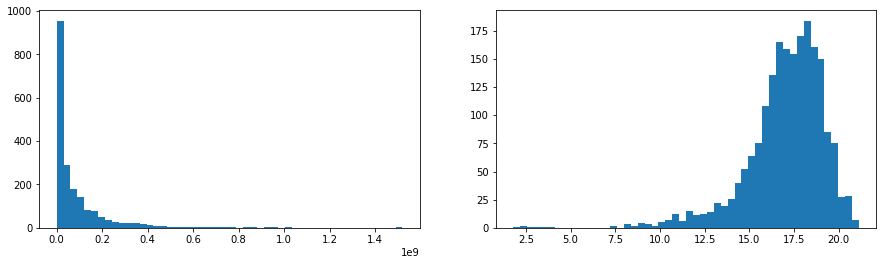

In [106]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1).hist(data.revenue,50)
plt.subplot(1, 2, 2).hist(np.log(data.revenue),50);

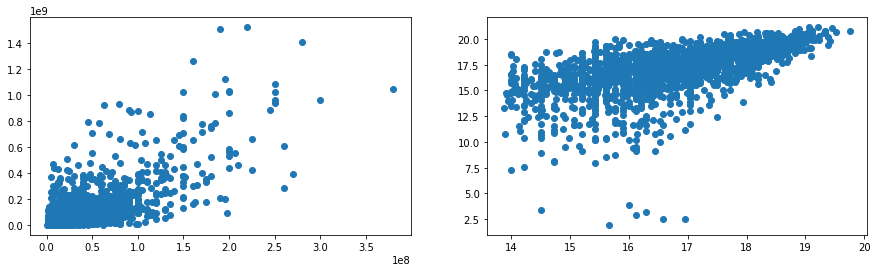

In [107]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1).scatter(data.budget, data.revenue);
plt.subplot(1, 2, 2).scatter(np.log1p(data.budget), np.log1p(data.revenue));


In [108]:
np.mean((data.budget-data.budget.mean()) * (data.revenue-data.revenue.mean())) / (data.budget.std() * data.revenue.std())

0.7336418909776768

In [109]:
#np.mean((np.log1p(data.budget)-np.log1p(data.budget).mean()) * (np.log1p(data.revenue)-np.log1p(data.revenue).mean())) / (np.log1p(data.budget).std() * np.log1p(data.revenue).std())

Usando la correlazione di Pearson si ottiene una buona correlazione tra le due variabili

**Genres**

Il genere è la prima feature di tipo dizionario. I valori distinti sono limitati, perciò si procede con la binarizzazione di tutti gli elementi

In [110]:
data["genres"] = (data['genres'].apply(lambda x: [i['name'] for i in eval(x)] if str(x) != 'nan' else []).values)
list_of_genres = {i for x in data.genres for i in x}
for genre in list_of_genres:
  data["genre_" + genre] = data['genres'].apply(lambda x: 1 if genre in x else 0)



data.drop(columns='genres',inplace=True)



In [111]:
test["genres"] = (test['genres'].apply(lambda x: [i['name'] for i in eval(x)] if str(x) != 'nan' else []).values)

for genre in list_of_genres:
  test["genre_" + genre] = test['genres'].apply(lambda x: 1 if genre in x else 0)



test.drop(columns='genres',inplace=True)


Per quanto riguara le features **imdb_id, 'original_title', 'status', 'poster_path'** e **title** di eliminarle in quanto poco significative

In [112]:
data.drop(columns=['imdb_id','original_title','status','poster_path', 'title'], inplace=True)
test.drop(columns=['imdb_id','original_title','status','poster_path', 'title'], inplace=True)

**Original_language**



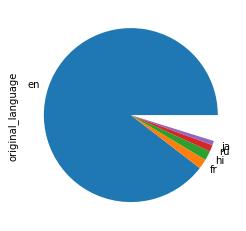

In [113]:
data.original_language.value_counts(normalize=True).head(5).plot.pie();


Per quanto a primo impatto potesse risultare un dato interessante, la maggior parte dei film sono in inglese, quindi risulterebbero inutili in fase di addestramento. Lo stesso ragionamento vale per **spoken_language**
Un discorso diverso invece va fatto con **popularity**. Non avendo certezza del fatto che il rating di popolarità sia antecedente alla fuoriuscita dei film, si decide cancellare la colonna assieme alle altre.

In [114]:
#data.drop(columns= ['original_language','spoken_languages', 'popularity'], inplace=True)
data.drop(columns= ['original_language','spoken_languages'], inplace=True)
test.drop(columns= ['original_language','spoken_languages'], inplace=True)

**Keywords**

In [115]:
data.Keywords.head()

id
1    [{'id': 4379, 'name': 'time travel'}, {'id': 9...
2    [{'id': 2505, 'name': 'coronation'}, {'id': 42...
3    [{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...
4    [{'id': 10092, 'name': 'mystery'}, {'id': 1054...
6                                                  NaN
Name: Keywords, dtype: object

**tagline** e **overview** svolgono la stessa funzione di **Keywords**, e cioè l'estrazione di parole chiavi da da associare a ciascun film. Si procede ad eliminarle.

In [116]:
data.drop(columns=['overview', 'tagline'], inplace=True)
test.drop(columns=['overview', 'tagline'], inplace=True)


Si definisce una funzione per l'estrazione dei nomi dai dizionari, la selezione dei 100 nomi piu' diffusi e la loro binarizzazione.

In [117]:
def cut_and_binariezed(feature):
  data[feature] = (data[feature].apply(lambda x: [i['name'] for i in eval(x)] if str(x) != 'nan' else []).values)

  test[feature] = (test[feature].apply(lambda x: [i['name'] for i in eval(x)] if str(x) != 'nan' else []).values)

  all_values = pd.DataFrame([i for x in data[feature] for i in x])
  
  split = all_values.value_counts()[:10]
  for keys in split.index:
      data[feature+" (" + keys[0]+ ")"] = data[feature].apply(lambda x: 1 if keys[0] in x else 0)
  data.drop(columns=feature,inplace=True) 

  for keys in split.index:
      test[feature+" (" + keys[0]+ ")"] = test[feature].apply(lambda x: 1 if keys[0] in x else 0)
  test.drop(columns=feature,inplace=True)


In [118]:
cut_and_binariezed("Keywords")

Si procede allo stesso modo con **cast**,**crew**,  **production_companies** e **production_countries**

In [119]:
for feature in ["cast","crew", "production_companies","production_countries"]:
  cut_and_binariezed(feature)

**Release Date**

Vengono create 3 feature rappresentanti giorno,mese, anno

In [120]:
data[['release_month', 'release_day', 'release_year']] = data['release_date'].str.split('/', expand=True).astype(int)

In [121]:
test.release_date.fillna("01/01/01", inplace=True)

In [122]:
test.release_date.notna().value_counts()

True    4398
Name: release_date, dtype: int64

In [123]:
test[['release_month', 'release_day', 'release_year']] = test['release_date'].str.split('/', expand=True).astype(int)

<BarContainer object of 76 artists>

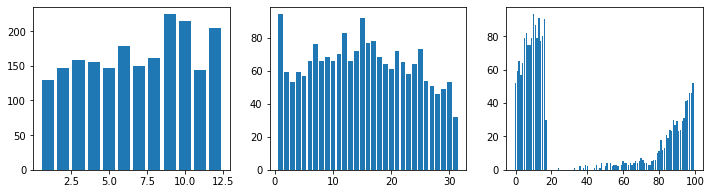

In [124]:
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1).bar(data.release_month.value_counts().index,data.release_month.value_counts().values)
plt.subplot(1, 3, 2).bar(data.release_day.value_counts().index,data.release_day.value_counts().values)
plt.subplot(1, 3, 3).bar(data.release_year.value_counts().index,data.release_year.value_counts().values)


Alcuni valori della feature **release_year** presentano solo le ultime cifre, perciò vanno uniformate 

<BarContainer object of 76 artists>

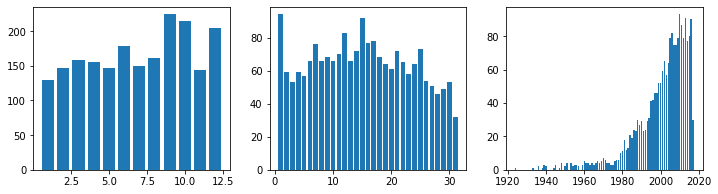

In [125]:
data["release_year"]=data['release_year'].map(lambda x: 2000 + x if x < 20 else (x+1900 if x<100 else x))
plt.figure(figsize=(12, 3))
plt.subplot(1, 3, 1).bar(data.release_month.value_counts().index,data.release_month.value_counts().values)
plt.subplot(1, 3, 2).bar(data.release_day.value_counts().index,data.release_day.value_counts().values)
plt.subplot(1, 3, 3).bar(data.release_year.value_counts().index,data.release_year.value_counts().values)

In [126]:
test["release_year"]=test['release_year'].map(lambda x: 2000 + x if x < 20 else (x+1900 if x<100 else x))
test.drop(columns='release_date', inplace=True)

In [127]:
data.drop(columns='release_date', inplace=True)

In [128]:
data.head(1)

,budget,popularity,runtime,revenue,belongs_to_a_collection,homepage_is_present,genre_Animation,genre_Music,genre_War,genre_Romance,genre_Comedy,genre_TV Movie,genre_Drama,genre_Mystery,genre_Western,genre_Documentary,genre_Foreign,genre_Thriller,genre_Action,genre_Science Fiction,genre_Adventure,genre_History,genre_Fantasy,genre_Family,genre_Crime,genre_Horror,Keywords (duringcreditsstinger),Keywords (woman director),Keywords (murder),Keywords (based on novel),Keywords (independent film),Keywords (violence),Keywords (dystopia),Keywords (aftercreditsstinger),Keywords (sport),Keywords (revenge),cast (Samuel L. Jackson),cast (Bruce Willis),cast (J.K. Simmons),cast (Morgan Freeman),cast (Bruce McGill),cast (Robert De Niro),cast (Nicolas Cage),cast (Jason Statham),cast (Owen Wilson),cast (George Clooney),crew (Robert Rodriguez),crew (Avy Kaufman),crew (James Newton Howard),crew (Francine Maisler),crew (Deborah Aquila),crew (Steven Spielberg),crew (Mary Vernieu),crew (Jerry Goldsmith),crew (Luc Besson),crew (Tricia Wood),production_companies (Warner Bros.),production_companies (Universal Pictures),production_companies (Paramount Pictures),production_companies (Twentieth Century Fox Film Corporation),production_companies (Columbia Pictures),production_companies (New Line Cinema),production_companies (Metro-Goldwyn-Mayer (MGM)),production_companies (Walt Disney Pictures),production_companies (Touchstone Pictures),production_companies (Columbia Pictures Corporation),production_countries (United States of America),production_countries (United Kingdom),production_countries (France),production_countries (Germany),production_countries (Canada),production_countries (India),production_countries (Australia),production_countries (Italy),production_countries (China),production_countries (Russia),release_month,release_day,release_year
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,14000000,6.575393,93.0,12314651,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,2,20,2015


**Runtime**

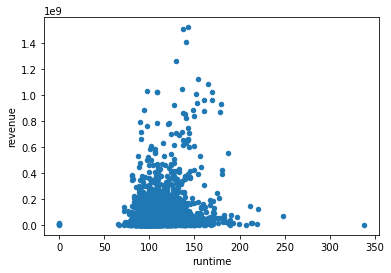

In [129]:
data.plot.scatter("runtime", "revenue")

In [130]:
data

,budget,popularity,runtime,revenue,belongs_to_a_collection,homepage_is_present,genre_Animation,genre_Music,genre_War,genre_Romance,genre_Comedy,genre_TV Movie,genre_Drama,genre_Mystery,genre_Western,genre_Documentary,genre_Foreign,genre_Thriller,genre_Action,genre_Science Fiction,genre_Adventure,genre_History,genre_Fantasy,genre_Family,genre_Crime,genre_Horror,Keywords (duringcreditsstinger),Keywords (woman director),Keywords (murder),Keywords (based on novel),Keywords (independent film),Keywords (violence),Keywords (dystopia),Keywords (aftercreditsstinger),Keywords (sport),Keywords (revenge),cast (Samuel L. Jackson),cast (Bruce Willis),cast (J.K. Simmons),cast (Morgan Freeman),cast (Bruce McGill),cast (Robert De Niro),cast (Nicolas Cage),cast (Jason Statham),cast (Owen Wilson),cast (George Clooney),crew (Robert Rodriguez),crew (Avy Kaufman),crew (James Newton Howard),crew (Francine Maisler),crew (Deborah Aquila),crew (Steven Spielberg),crew (Mary Vernieu),crew (Jerry Goldsmith),crew (Luc Besson),crew (Tricia Wood),production_companies (Warner Bros.),production_companies (Universal Pictures),production_companies (Paramount Pictures),production_companies (Twentieth Century Fox Film Corporation),production_companies (Columbia Pictures),production_companies (New Line Cinema),production_companies (Metro-Goldwyn-Mayer (MGM)),production_companies (Walt Disney Pictures),production_companies (Touchstone Pictures),production_companies (Columbia Pictures Corporation),production_countries (United States of America),production_countries (United Kingdom),production_countries (France),production_countries (Germany),production_countries (Canada),production_countries (India),production_countries (Australia),production_countries (Italy),production_countries (China),production_countries (Russia),release_month,release_day,release_year
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,14000000,6.575393,93.0,12314651,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,2,20,2015
2,40000000,8.248895,113.0,95149435,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,8,6,2004
3,3300000,64.299990,105.0,13092000,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,10,10,2014
4,1200000,3.174936,122.0,16000000,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3,9,2012
6,8000000,0.743274,83.0,3261638,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,6,1987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2993,1135654,3.878515,149.0,1213880,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,18,1924
2994,60000000,14.092373,128.0,219417255,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,6,17,2004
2998,65000000,14.482345,120.0,89456761,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,10,11,1996


# Addestramento


In [131]:
data.isna().sum()

budget                           0
popularity                       0
runtime                          1
revenue                          0
belongs_to_a_collection          0
                                ..
production_countries (China)     0
production_countries (Russia)    0
release_month                    0
release_day                      0
release_year                     0
Length: 79, dtype: int64

In [132]:
test.runtime.fillna(0, inplace=True)

In [133]:
test.isnull().sum().sum()

0

In [134]:
data.dropna(inplace=True)
#test.dropna(inplace=True)

In [135]:
data.shape

(2011, 79)

In [136]:
test.shape

(4398, 78)

In [137]:
Y_data = data.revenue
X_data = data.drop(columns='revenue')
#X_data = data.loc[:,['budget','popularity', 'runtime']]

In [138]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error

In [139]:


# definisco funzione per errore relativo
def relative_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true))

# funzione per calcolare e stampare tutte e tre
def print_eval(X, y, model):
    preds = model.predict(X)
    print("   Mean squared error: {:.5}".format(mean_squared_error(y, preds)))
    print("   Mean squared log error: {:.5}".format(np.sqrt(mean_squared_log_error(y, np.abs(preds)))))
    print("       Relative error: {:.5%}".format(relative_error(y, preds)))
    print("R-squared coefficient: {:.5}".format(r2_score(y, preds)))

In [140]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = \
    train_test_split(X_data, Y_data, test_size=1/3, random_state=42)

In [141]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("lrn",  LinearRegression())
])
model.fit(X_train, y_train)
print_eval(X_val, y_val, model)

   Mean squared error: 9.5197e+15
   Mean squared log error: 2.0998
       Relative error: 542989.55507%
R-squared coefficient: 0.65394


In [142]:
from sklearn.linear_model import Lasso
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr", Lasso(alpha=1))
])
model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regr',
                 Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
                       normalize=False, positive=False, precompute=False,
                       random_state=None, selection='cyclic', tol=0.0001,
                       warm_start=False))],
         verbose=False)

Ci troviamo di fronte fin da subito all'evidenza di una discreta descrizione del modello, alla quale non corrisponde però una altrettanta minimizzazione dell'errore. Ciò è dovuto principalmente all'andamento esponenziale della variabile **budget** e della variabile target **revenue**. Si decide perciò di usare la funzione log(1+x) per effetturare una trasformazione in modo di avere una migliore modelizzazione

In [143]:
#data.budget = np.log1p(data.budget)
#data.revenue = np.log1p(data.revenue)
#Y_data = data.revenue
#X_data = data.drop(columns='revenue')
#X_train, X_val, y_train, y_val = \
 #   train_test_split(X_data, Y_data, test_size=1/3, random_state=42)

In [144]:
from sklearn.kernel_ridge import KernelRidge
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

In [145]:
model = Pipeline([
    ("scale", StandardScaler()),
    ("regr",  KernelRidge(alpha=1, kernel="poly", degree=2))
])
model.fit(X_train, y_train);

In [146]:
print_eval(X_val, y_val, model)

   Mean squared error: 8.1243e+15
   Mean squared log error: 2.0065
       Relative error: 447357.50604%
R-squared coefficient: 0.70466


In [147]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=8, random_state=42)
model.fit(X_train, y_train);

In [148]:
print_eval(X_train, y_train, model)

   Mean squared error: 2.0302e+15
   Mean squared log error: 1.696
       Relative error: 976067.23351%
R-squared coefficient: 0.91779


In [149]:
print_eval(X_val, y_val, model)

   Mean squared error: 1.429e+16
   Mean squared log error: 1.8676
       Relative error: 203787.49710%
R-squared coefficient: 0.48053


In [150]:
res1 = model.predict(test)

In [151]:
model = DecisionTreeRegressor(min_samples_split=0.4, random_state=42)
model.fit(X_train, y_train);

In [152]:
model.score(X_train, y_train)

0.4969336588663307

In [153]:
model.score(X_val, y_val)

0.40528901181773447

In [154]:
print_eval(X_val, y_val, model)

   Mean squared error: 1.636e+16
   Mean squared log error: 2.0612
       Relative error: 634266.86746%
R-squared coefficient: 0.40529


In [155]:
model = DecisionTreeRegressor(random_state=42)
grid = {
    "max_depth": [3, 5, 10, None],
    "min_samples_split": [2, 0.02, 0.05, 0.1]
}
kf = KFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, grid, cv=kf)
gs.fit(X_train, y_train)
gs.best_params_

{'max_depth': 5, 'min_samples_split': 0.1}

In [156]:
gs.score(X_val, y_val)

0.485507147712153

In [157]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(
    hidden_layer_sizes=[4],
    activation="relu",
    solver="sgd",
    random_state=12345
)

In [158]:
model.fit(X_train, y_train);

In [159]:
model.score(X_val, y_val)

-3.6236673215761545e+45

In [160]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [161]:
model = Sequential([
    Dense(128, activation="relu", input_dim=X_train.shape[1]),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_logarithmic_error")

In [162]:
model.fit(X_train, y_train, batch_size=100, epochs=5)


Epoch 1/5
14/14 [==============================] - 0s 2ms/step - loss: 6.5719
Epoch 2/5
14/14 [==============================] - 0s 3ms/step - loss: 4.9846
Epoch 3/5
14/14 [==============================] - 0s 2ms/step - loss: 4.3287
Epoch 4/5
14/14 [==============================] - 0s 2ms/step - loss: 3.9909
Epoch 5/5
14/14 [==============================] - 0s 2ms/step - loss: 3.7764


In [163]:
model = Sequential([
    Dense(512, activation="relu", input_dim=X_train.shape[1]),
    Dense(128, activation="relu"),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_logarithmic_error")

In [164]:
model.fit(X_train, y_train, batch_size=100, epochs=5)

Epoch 1/5
14/14 [==============================] - 1s 4ms/step - loss: 8.2976
Epoch 2/5
14/14 [==============================] - 0s 5ms/step - loss: 4.4178
Epoch 3/5
14/14 [==============================] - 0s 5ms/step - loss: 3.7657
Epoch 4/5
14/14 [==============================] - 0s 5ms/step - loss: 3.4184
Epoch 5/5
14/14 [==============================] - 0s 5ms/step - loss: 3.2481


In [165]:
from tensorflow.keras.regularizers import l2
model = Sequential([
    Dense(128, activation="relu", kernel_regularizer=l2(0.001), input_dim=X_train.shape[1]),
    Dense(1)
])
model.compile(optimizer="adam", loss="mean_squared_logarithmic_error")

In [166]:
model.fit(X_train, y_train, batch_size=100, epochs=50)

Epoch 1/50
14/14 [==============================] - 0s 2ms/step - loss: 294.7389
Epoch 2/50
14/14 [==============================] - 0s 2ms/step - loss: 294.7190
Epoch 3/50
14/14 [==============================] - 0s 2ms/step - loss: 294.7031
Epoch 4/50
14/14 [==============================] - 0s 3ms/step - loss: 294.6906
Epoch 5/50
14/14 [==============================] - 0s 2ms/step - loss: 294.6809
Epoch 6/50
14/14 [==============================] - 0s 2ms/step - loss: 294.6735
Epoch 7/50
14/14 [==============================] - 0s 3ms/step - loss: 294.6679
Epoch 8/50
14/14 [==============================] - 0s 2ms/step - loss: 46.3264
Epoch 9/50
14/14 [==============================] - 0s 2ms/step - loss: 12.0265
Epoch 10/50
14/14 [==============================] - 0s 2ms/step - loss: 9.9203
Epoch 11/50
14/14 [==============================] - 0s 2ms/step - loss: 8.3134
Epoch 12/50
14/14 [==============================] - 0s 3ms/step - loss: 6.9737
Epoch 13/50
14/14 [==============

In [167]:
res1 = model.predict(test)

In [168]:
X_train.head(1)

,budget,popularity,runtime,belongs_to_a_collection,homepage_is_present,genre_Animation,genre_Music,genre_War,genre_Romance,genre_Comedy,genre_TV Movie,genre_Drama,genre_Mystery,genre_Western,genre_Documentary,genre_Foreign,genre_Thriller,genre_Action,genre_Science Fiction,genre_Adventure,genre_History,genre_Fantasy,genre_Family,genre_Crime,genre_Horror,Keywords (duringcreditsstinger),Keywords (woman director),Keywords (murder),Keywords (based on novel),Keywords (independent film),Keywords (violence),Keywords (dystopia),Keywords (aftercreditsstinger),Keywords (sport),Keywords (revenge),cast (Samuel L. Jackson),cast (Bruce Willis),cast (J.K. Simmons),cast (Morgan Freeman),cast (Bruce McGill),cast (Robert De Niro),cast (Nicolas Cage),cast (Jason Statham),cast (Owen Wilson),cast (George Clooney),crew (Robert Rodriguez),crew (Avy Kaufman),crew (James Newton Howard),crew (Francine Maisler),crew (Deborah Aquila),crew (Steven Spielberg),crew (Mary Vernieu),crew (Jerry Goldsmith),crew (Luc Besson),crew (Tricia Wood),production_companies (Warner Bros.),production_companies (Universal Pictures),production_companies (Paramount Pictures),production_companies (Twentieth Century Fox Film Corporation),production_companies (Columbia Pictures),production_companies (New Line Cinema),production_companies (Metro-Goldwyn-Mayer (MGM)),production_companies (Walt Disney Pictures),production_companies (Touchstone Pictures),production_companies (Columbia Pictures Corporation),production_countries (United States of America),production_countries (United Kingdom),production_countries (France),production_countries (Germany),production_countries (Canada),production_countries (India),production_countries (Australia),production_countries (Italy),production_countries (China),production_countries (Russia),release_month,release_day,release_year
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
495,2000000,2.300459,97.0,0,1,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,10,10,2009


In [169]:
if not os.path.exists("sample_submission.csv"):
    from urllib.request import urlretrieve
    urlretrieve("https://raw.githubusercontent.com/sergiorolnic/datascience/main/sample_submission.csv", "sample_submission.csv")

sub = pd.read_csv("sample_submission.csv")  
df_sub = pd.DataFrame()
df_sub['id'] = sub['id']

In [170]:
#res1 = model.predict(test)
#df_sub["revenue"] = res1
#df_sub.to_csv("./submission.csv", index=False)

In [171]:
df_sub["revenue"] = np.abs(res1)
df_sub.to_csv("./submission.csv", index=False)